# <a id='toc1_'></a>[SI618 Project 3 Classification](#toc0_)

# <a id='toc2_'></a>[Project Title: World of Board Games: What decide their popularity and ratings?](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [SI618 Project 3 Classification](#toc1_)    
- [Project Title: World of Board Games: What decide their popularity and ratings?](#toc2_)    
  - [Target](#toc2_1_)    
  - [Import data](#toc2_2_)    
  - [Creating Classification Task](#toc2_3_)    
    - [Reasoning](#toc2_3_1_)    
    - [Create Classes](#toc2_3_2_)    
  - [Our tasks overview: Preprocessing and Classification.](#toc2_4_)    
  - [Data Processing](#toc2_5_)    
    - [Columns: keep, change, or discard?](#toc2_5_1_)    
    - [Pipeline and Model Preparation](#toc2_5_2_)    
  - [Models](#toc2_6_)    
    - [Logistic regression](#toc2_6_1_)    
      - [Parameters interpretation](#toc2_6_1_1_)    
    - [Improved Logistic Regression](#toc2_6_2_)    
    - [KNN](#toc2_6_3_)    
    - [PCA](#toc2_6_4_)    
    - [LDA and QDA](#toc2_6_5_)    
    - [Random Forest](#toc2_6_6_)    
    - [XGBOOST](#toc2_6_7_)    
    - [Ensemble Model](#toc2_6_8_)    
  - [Interpretation, Conclusion, Reflection](#toc2_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Team members:

- Keqing Lu (keqinglu)
- Xiyuan Wang (denniswx)
- Fangqing Yuan (fangqing)

## <a id='toc2_1_'></a>[Target](#toc0_)

Our key question raised in the previous part is: **"What factors affect the rating of board games?"**

We then transform this question into a classification task: **Predict which rating class a board game belongs to by its features**

## <a id='toc2_2_'></a>[Import data](#toc0_)

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import processed data from project 1
ready_data = pd.read_pickle('board_games.pkl')

## <a id='toc2_3_'></a>[Creating Classification Task](#toc0_)

### <a id='toc2_3_1_'></a>[Reasoning](#toc0_)

In our data, `average` are the average ratings of each board game, and they are float numbers. To create a classification task, As suggested by GSI in part 2 comments, we intended to create a column to divide average ratings into three levels: low, medium, high, by using the 1/3 and 2/3 quantiles.

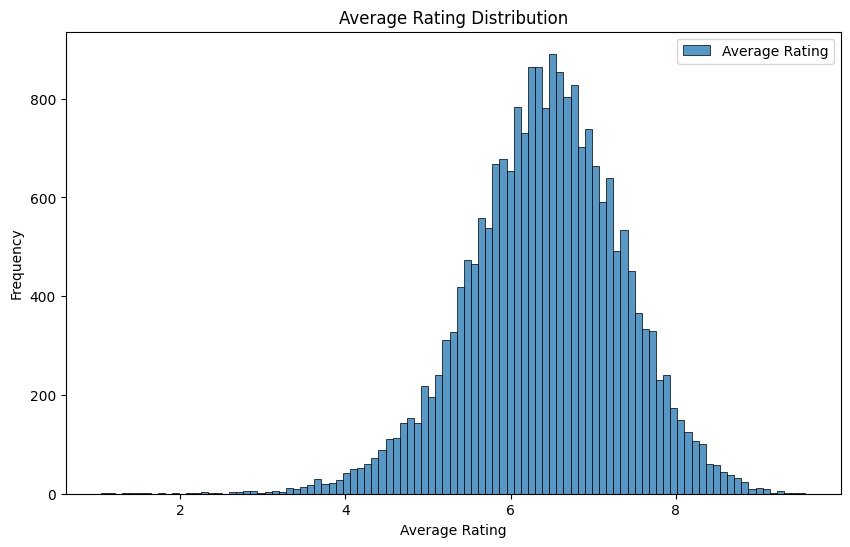

In [4]:
# histogram of the average ratings
plt.figure(figsize=(10, 6))
sns.histplot(ready_data['average'])
plt.title('Average Rating Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.legend(['Average Rating'])
plt.show()

We can see that the average ratings have an approximately Gaussian distribution. It could be problematic if we divide them into three classes:

- Percentiles would be arbitrarily chosen based on the sample, which has no significant real-life meaning
- The middle class, `medium`, would potentially cause huge noise to the model, as the boundaries with `low` and `high` classes would be blurry
- On contrary, having only two classes focusing on the lower and higher ratings would provide clear insights on what make a board game quite bad or good
- Leaving the middle class would be ok as they are the most common and mediocre games who have no specific high or low ratings.

**NOTE**: The above reasoning on deciding classes were discussed, suggested, and approved by Prof. Teplovs

### <a id='toc2_3_2_'></a>[Create Classes](#toc0_)

In [5]:
# mean and standard deviation of the average ratings
mean = ready_data['average'].mean()
std = ready_data['average'].std()
print('Mean:', mean)
print('Standard Deviation:', std)

Mean: 6.41724931810827
Standard Deviation: 0.929344857813654


In real life, we always set 6/10 as a "passing" score. Based on the sample mean and standard deviation, we can see that 6 is approximately $\mu-0.5\sigma$, where $\mu$ is the population mean and $\sigma^2$ is the population variance. We may see ratings between 6 and 7 as "mediocre", and 7+ as good ratings.

Also, on our data [source website](https://boardgamegeek.com/wiki/page/ratings) [**<font color = red>1</font>**](#reference), the criteria of ratings are as following:

- 7: Good game, usually willing to play.
- 6: Ok game, some fun or challenge at least, will play sporadically if in the right mood.

This would further justify our decision on regarding 6- as bad ratings and 7+ as good ratings.

We decided to label games with average ratings lower than 6 as `low`, and those with average ratings higher than 7 as `high`, ignoring the games whose average ratings are in the middle.

In [6]:
ready_data['rate_cat'] = ready_data['average'].apply(lambda x: 'High' if x >= 7 else ('Low' if x < 6 else 'Medium'))

In [7]:
# checking the new columns
ready_data.rate_cat.value_counts()

rate_cat
Medium    9235
Low       6629
High      5767
Name: count, dtype: int64

We would discard the rows with medium/mediocre ratings. The distribution of low and high seems balanced enough.

In [9]:
# drop row where rate_cat is 'Medium'
ready_data = ready_data[ready_data.rate_cat != 'Medium']

Overview of the data after assigning classes:

In [10]:
ready_data.head().T

,0,1,2,3,4
num_x,105,189,428,72,103
id,30549,822,13,68448,36218
name,Pandemic,Carcassonne,Catan,7 Wonders,Dominion
year,2008,2000,1995,2010,2008
rank,106,190,429,73,104
average,7.59,7.42,7.14,7.74,7.61
bayes_average,7.487,7.309,6.97,7.634,7.499
users_rated,108975,108738,108024,89982,81561
url,/boardgame/30549/pandemic,/boardgame/822/carcassonne,/boardgame/13/catan,/boardgame/68448/7-wonders,/boardgame/36218/dominion
thumbnail,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...


In [11]:
ready_data.shape

(12396, 41)

## <a id='toc2_4_'></a>[Our tasks overview: Preprocessing and Classification.](#toc0_)

- Preprocessing
  - Import data: Done
  - Get new classification column: done
  - Missing value: After project 2, there is no NaN
  - Outliers: discard or impute?
  - Delete unnecessary columns (id, url, description)
  - Combine similar columns (platers, playtime, own/wish/want/trade/rate)
  - List: (two choices)
    - use list_count
    - choose top x categories and make dummy variables
  - Pipeline: scaling, standardize, dummy variable
  - PCA (optional)
- Classification
  - train_test_split, stratification
  - LR, LDA, QDA, KNN, Tree, RF, XGBoost, SVM, try them all
  - Design model measurement: precision, accuracy score, F1, recall, AUC (be careful, we have a 3-class category)
  - Cross Validation to get optimal parameters (fine tuning the hyper-parameters)
  - Interpretation

## <a id='toc2_5_'></a>[Data Processing](#toc0_)

### <a id='toc2_5_1_'></a>[Columns: keep, change, or discard?](#toc0_)

We first discard columns of `num_x` and `num_y`, and `primary`, `url`, `thumbnail` and `description` columns from the dataset, as they are purely identifiers or text information of the entries and not useful or not quantifiable for classification analysis.

We use the column `id` as the DataFrame index, which is unique for each row. We kept the `name` column for visualization.

In [45]:
core_data = ready_data.drop(columns=['num_x', 'num_y', 'primary', 'url', 'thumbnail', 'description'])
# re-index the dataframe with column 'id'
core_data.set_index('id', inplace=True)

For the columns of lists that contain various attributes of the games, we want to transform them into singular values before we could use for classification. Some of them are unique with every game, such as `family`, `expansion` and `implementation`, so we discard them right away. For others like `artist`, `designer` and `publisher`, although there are common values across the games, from part 2 we have shown that there are too many of them and the distribution is very scattered across all games. We would need to have too many dummy variables to encode them, so we do not take them into consideration. For `category` and `mechanic`, the most common types consist a significant portion of the games, so we can use dummy variables to encode them. We keep the counts of all these category lists, which can represent the engagement of making the game, the complexity of the game and the number of derivation from the game.

In [46]:
core_data.drop(columns=['family_list', 'expansion_list', 'implementation_list', 'artist_list', 'designer_list', 'publisher_list'], inplace=True)

Also, in part 2, we have explored the relationship of variables that represent game rating, game popularity, player number and playing time.
- For game popularity, given the high correlation between the variables (`users_rated`, `owned`, `trading`, `wanting`, `wishing`), we choose `owned` + `users_rated` to represent ownership, and `trading` + `wanting` + `wishing` to represent the desire to own.
- Also, given the high correlation of min and max playing time, we use `playingtime` to denote it, as it is the same as the max playing time. It has some potential outliers we may need to deal with. Due to the huge outliers present in the games, we can impute the playing time of over 180 minutes to 180.
- For player numbers, the min and max values are not as strongly correlated, and we can consider them separately.
- For publishing year, we keep `yearpublished` and discard `year`

In [47]:
core_data.drop(columns=['year', 'rank', 'average', 'bayes_average', 'minplaytime', 'maxplaytime'], inplace=True)
core_data['own+rate'] = core_data['owned'] + core_data['users_rated']
core_data['desired'] = core_data['wanting'] + core_data['wishing'] + core_data['trading']
core_data.drop(columns=['owned', 'users_rated', 'wanting', 'wishing', 'trading'], inplace=True)

In [48]:
# checking most popular category and mechanic
top_categories = core_data.category_list.explode().value_counts().head(3)
print(top_categories)

top_mechanics = core_data.mechanic_list.explode().value_counts().head(3)
print(top_mechanics)

category_list
Card Game    3475
Wargame      2336
Fantasy      1587
Name: count, dtype: int64
mechanic_list
Dice Rolling              3694
Hand Management           2397
Variable Player Powers    1655
Name: count, dtype: int64


In [49]:
# we focus on Card Game and Dice Rolling
core_data['is_cardgame'] = core_data['category_list'].apply(lambda x: 1 if 'Card Game' in x else 0)
core_data['is_dicerolling'] = core_data['mechanic_list'].apply(lambda x: 1 if 'Dice Rolling' in x else 0)
core_data.drop(columns=['category_list', 'mechanic_list'], inplace=True)

In [50]:
core_data['playingtime'] = core_data['playingtime'].apply(lambda x: x if x < 180 else 180)

There are games that are from ancient time, so the `yearpublished` was -3500. We will change that into a more reasonable value.

In [52]:
# change yearpublished whose value is smaller than 1960 to 1960
core_data['yearpublished'] = core_data['yearpublished'].apply(lambda x: 1960 if x < 1960 else x)

In [54]:
core_data.describe().T

,count,mean,std,min,25%,50%,75%,max
yearpublished,12396.0,2006.180865,14.503999,1960.0,2001.0,2011.0,2017.0,2023.0
minplayers,12396.0,1.971926,0.667957,0.0,2.0,2.0,2.0,9.0
maxplayers,12396.0,5.788722,13.706047,0.0,4.0,4.0,6.0,999.0
playingtime,12396.0,65.233624,54.037950,0.0,30.0,45.0,90.0,180.0
minage,12396.0,9.599548,3.823941,0.0,8.0,10.0,12.0,25.0
category_count,12396.0,2.663843,1.403742,0.0,2.0,2.0,3.0,14.0
family_count,12396.0,2.333898,2.655035,0.0,1.0,2.0,3.0,106.0
mechanic_count,12396.0,2.998064,2.361790,0.0,1.0,2.0,4.0,20.0
expansion_count,12396.0,1.778638,9.643063,0.0,0.0,0.0,1.0,525.0
implementation_count,12396.0,0.309616,0.935504,0.0,0.0,0.0,0.0,38.0


Looking at the description, there are more columns which need modification:

- Large outliers in `maxplayers`, `family_count`, `expansion_count`, `implementation_count`, `publisher_count`, `artist_count`
- Those outliers may be transformed, or the columns could be transformed into binary variables
- `own+rate` and `desired` may need log scale transformation

In [62]:
# change values in `maxplayers`, `family_count`, `publisher_count`, `artist_count` with values larger than 95% percentile into that 95% percentile
maxplayers_95 = core_data['maxplayers'].quantile(0.95)
family_count_95 = core_data['family_count'].quantile(0.95)
publisher_count_95 = core_data['publisher_count'].quantile(0.95)
artist_count_95 = core_data['artist_count'].quantile(0.95)

core_data['maxplayers'] = core_data['maxplayers'].apply(lambda x: maxplayers_95 if x > maxplayers_95 else x)
core_data['family_count'] = core_data['family_count'].apply(lambda x: family_count_95 if x > family_count_95 else x)
core_data['publisher_count'] = core_data['publisher_count'].apply(lambda x: publisher_count_95 if x > publisher_count_95 else x)
core_data['artist_count'] = core_data['artist_count'].apply(lambda x: artist_count_95 if x > artist_count_95 else x)

# change `expansion_count`, `implementation_count` into 0 and 1
core_data['expansion_count'] = core_data['expansion_count'].apply(lambda x: 1 if x > 0 else 0)
core_data['implementation_count'] = core_data['implementation_count'].apply(lambda x: 1 if x > 0 else 0)

In [65]:
# change values in category_count, mechanic_count, designer_count with values larger than 95% percentile into that 95% percentile
category_count_95 = core_data['category_count'].quantile(0.95)
mechanic_count_95 = core_data['mechanic_count'].quantile(0.95)
designer_count_95 = core_data['designer_count'].quantile(0.95)

core_data['category_count'] = core_data['category_count'].apply(lambda x: category_count_95 if x > category_count_95 else x)
core_data['mechanic_count'] = core_data['mechanic_count'].apply(lambda x: mechanic_count_95 if x > mechanic_count_95 else x)
core_data['designer_count'] = core_data['designer_count'].apply(lambda x: designer_count_95 if x > designer_count_95 else x)

In [67]:
# make own+rate and desired into log scale
core_data['own+rate'] = np.log1p(core_data['own+rate'])
core_data['desired'] = np.log1p(core_data['desired'])

In [68]:
core_data.describe().T

,count,mean,std,min,25%,50%,75%,max
yearpublished,12396.0,2006.180865,14.503999,1960.000000,2001.000000,2011.000000,2017.000000,2023.000000
minplayers,12396.0,1.971926,0.667957,0.000000,2.000000,2.000000,2.000000,9.000000
maxplayers,12396.0,4.606567,2.180522,0.000000,4.000000,4.000000,6.000000,10.000000
playingtime,12396.0,65.233624,54.037950,0.000000,30.000000,45.000000,90.000000,180.000000
minage,12396.0,9.599548,3.823941,0.000000,8.000000,10.000000,12.000000,25.000000
category_count,12396.0,2.599952,1.228581,0.000000,2.000000,2.000000,3.000000,5.000000
family_count,12396.0,2.182236,1.748839,0.000000,1.000000,2.000000,3.000000,6.000000
mechanic_count,12396.0,2.921991,2.125045,0.000000,1.000000,2.000000,4.000000,8.000000
expansion_count,12396.0,0.264117,0.440880,0.000000,0.000000,0.000000,1.000000,1.000000
implementation_count,12396.0,0.215553,0.411222,0.000000,0.000000,0.000000,0.000000,1.000000


### <a id='toc2_5_2_'></a>[Pipeline and Model Preparation](#toc0_)

Now that we have our preprocessed data, we can apply the train-test split and use scaling/encoding for the numerical/categorical variables.

In [69]:
# import pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# import PCA
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [71]:
# split train_data_transformed into 20% validation set and 80% training set with stratify on rate_cat
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(core_data, test_size=0.2, random_state=42, stratify=core_data['rate_cat'])

In [74]:
# get train and test X and y
train_X = train_data.drop(columns=['rate_cat', 'name'])
train_y = train_data['rate_cat']
test_X = test_data.drop(columns=['rate_cat', 'name'])
test_y = test_data['rate_cat']
# fit X into pipeline
train_X = pipe.fit_transform(train_X)
test_X = pipe.transform(test_X)
# change y into binary
train_y = train_y.apply(lambda x: 1 if x == 'High' else 0)
test_y = test_y.apply(lambda x: 1 if x == 'High' else 0)

## <a id='toc2_6_'></a>[Models](#toc0_)

### <a id='toc2_6_1_'></a>[Logistic regression](#toc0_)

In [76]:
# logistic regression
from sklearn.linear_model import LogisticRegression
# accuracy precision, F1, recall, confusion matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

logistic = LogisticRegression(random_state=42)
logistic.fit(train_X, train_y)
logistic_pred = logistic.predict(test_X)
logistic_pred_train = logistic.predict(train_X)
# store train and test accuracy, precision, F1, recall into a dataframe and print it out
logistic_train_accuracy = accuracy_score(train_y, logistic_pred_train)
logistic_test_accuracy = accuracy_score(test_y, logistic_pred)
logistic_train_precision = precision_score(train_y, logistic_pred_train)
logistic_test_precision = precision_score(test_y, logistic_pred)
logistic_train_f1 = f1_score(train_y, logistic_pred_train)
logistic_test_f1 = f1_score(test_y, logistic_pred)
logistic_train_recall = recall_score(train_y, logistic_pred_train)
logistic_test_recall = recall_score(test_y, logistic_pred)
# store them into DataFrame and print out
logistic_scores = pd.DataFrame({
    'Train': [logistic_train_accuracy, logistic_train_precision, logistic_train_f1, logistic_train_recall],
    'Test': [logistic_test_accuracy, logistic_test_precision, logistic_test_f1, logistic_test_recall]
}, index=['Accuracy', 'Precision', 'F1', 'Recall'])
print(logistic_scores)

              Train      Test
Accuracy   0.885034  0.864919
Precision  0.888045  0.881640
F1         0.874560  0.849573
Recall     0.861478  0.819757


The measurements are not bad. We intend to use this logistic regression model as a baseline model. Also, the parameters in logistic regression would help us interpret the model and get the idea of the relationship among features and ratings.

#### <a id='toc2_6_1_1_'></a>[Parameters interpretation](#toc0_)

In [78]:
# get Logistic regression parameters
logistic_params = logistic.coef_
# get the feature names
feature_names = core_data.drop(columns=['rate_cat', 'name']).columns
# get the feature paras
logistic_params = pd.DataFrame(logistic_params, columns=feature_names)
# print out the feature importance
print(logistic_params)

   yearpublished  minplayers  maxplayers  playingtime    minage  \
0       1.053606   -0.130519   -0.354828     0.818845 -0.009414   

   category_count  family_count  mechanic_count  expansion_count  \
0       -0.131134      0.377061         0.40963         0.365597   

   implementation_count  designer_count  publisher_count  artist_count  \
0              0.409919        0.040689         0.270631      0.114782   

   own+rate   desired  is_cardgame  is_dicerolling  
0 -2.098187  2.970387     0.077184        0.016215  


Notable parameters:

- Newer games tend to have higher ratings
- longer playing time tend to have higher ratings
- `own+rate` and `desired` have large opposite parameters, which could be caused by the high correlation they share, so we may either remove one of them, or apply stronger L1/L2 penalty
- Diversity in family, mechanic, expansion, implementation, publisher, and artist would benefit the ratings of the games

### <a id='toc2_6_2_'></a>[Improved Logistic Regression](#toc0_)

In [81]:
# using cross validation to find the optimal logistic regression with L2 penalty
from sklearn.model_selection import GridSearchCV

logistic = LogisticRegression(random_state=42)
param_grid = {
    'C': np.logspace(-10, 10, 20),
    'penalty': ['l2']
}
logistic_cv = GridSearchCV(logistic, param_grid, cv=5)
logistic_cv.fit(train_X, train_y)
# get best model and print parameters
best_logistic = logistic_cv.best_estimator_
print(best_logistic)

logistic_params = pd.DataFrame(best_logistic.coef_, columns=feature_names)
# print out the feature importance
print(logistic_params)

LogisticRegression(C=0.2976351441631313, random_state=42)
   yearpublished  minplayers  maxplayers  playingtime    minage  \
0       1.051035   -0.132596   -0.353888     0.811559 -0.008018   

   category_count  family_count  mechanic_count  expansion_count  \
0       -0.128774      0.373095        0.412184         0.362103   

   implementation_count  designer_count  publisher_count  artist_count  \
0              0.402954        0.040452         0.257777      0.114863   

   own+rate   desired  is_cardgame  is_dicerolling  
0 -2.005839  2.868869     0.071244        0.014693  


Most parameters did not change too much.

In [82]:
# design function to report train and test accuracy, precision, F1, recall from the input model
def report_model(model):
    model.fit(train_X, train_y)
    model_pred = model.predict(test_X)
    model_pred_train = model.predict(train_X)
    model_train_accuracy = accuracy_score(train_y, model_pred_train)
    model_test_accuracy = accuracy_score(test_y, model_pred)
    model_train_precision = precision_score(train_y, model_pred_train)
    model_test_precision = precision_score(test_y, model_pred)
    model_train_f1 = f1_score(train_y, model_pred_train)
    model_test_f1 = f1_score(test_y, model_pred)
    model_train_recall = recall_score(train_y, model_pred_train)
    model_test_recall = recall_score(test_y, model_pred)
    model_scores = pd.DataFrame({
        'Train': [model_train_accuracy, model_train_precision, model_train_f1, model_train_recall],
        'Test': [model_test_accuracy, model_test_precision, model_test_f1, model_test_recall]
    }, index=['Accuracy', 'Precision', 'F1', 'Recall'])
    return model_scores

In [83]:
report_model(best_logistic)

,Train,Test
Accuracy,0.885135,0.866532
Precision,0.888765,0.883504
F1,0.874573,0.851370
Recall,0.860828,0.821490


### <a id='toc2_6_3_'></a>[KNN](#toc0_)

KNeighborsClassifier(n_neighbors=15)


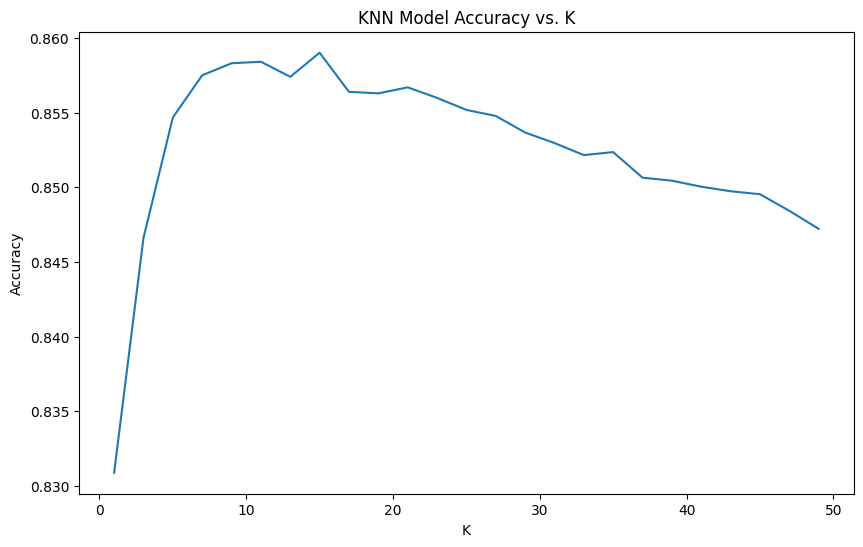

In [84]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

# use CV to find the best KNN model parameter
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.arange(1, 50, 2)
}
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(train_X, train_y)
# get best model and print parameters
best_knn = knn_cv.best_estimator_
print(best_knn)
# plot model accuracy against dofferent k
plt.figure(figsize=(10, 6))
plt.plot(param_grid['n_neighbors'], knn_cv.cv_results_['mean_test_score'])
plt.title('KNN Model Accuracy vs. K')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

The best k on CV is 15. We may see that the CV accuracy increases first when k gets larger and then decreases. Too small k would end up over-fitting while too large k would compromise model accuracy.

In [85]:
report_model(best_knn)

,Train,Test
Accuracy,0.874445,0.860484
Precision,0.905002,0.904000
F1,0.858055,0.839369
Recall,0.815738,0.783362


We may notice that the KNN model is slightly worse than logistic regression overall, but KNN has quite high precision, which means it predicts positive (high ratings) data points well, but not negative (low ratings) games. We may demonstrate it in confusion matrices:

In [86]:
# get the confusion matrix on test data of best logistic regression and KNN
logistic_confusion = confusion_matrix(test_y, best_logistic.predict(test_X))
knn_confusion = confusion_matrix(test_y, best_knn.predict(test_X))
print('Logistic Regression Confusion Matrix:')
print(logistic_confusion)
print('KNN Confusion Matrix:')
print(knn_confusion)

Logistic Regression Confusion Matrix:
[[1201  125]
 [ 206  948]]
KNN Confusion Matrix:
[[1230   96]
 [ 250  904]]


The precision on predicting positive class (high ratings) could be seen from the first row of the matrix. We may see that in KNN more positive classes were predicted correctly.

### <a id='toc2_6_4_'></a>[PCA](#toc0_)

The performance of KNN suggest us that, before exploring other models, we may take a look into how the games are distributed, if there is any notable clusters. A PCA, especially a 2-dimension PCA would help me visualize it.

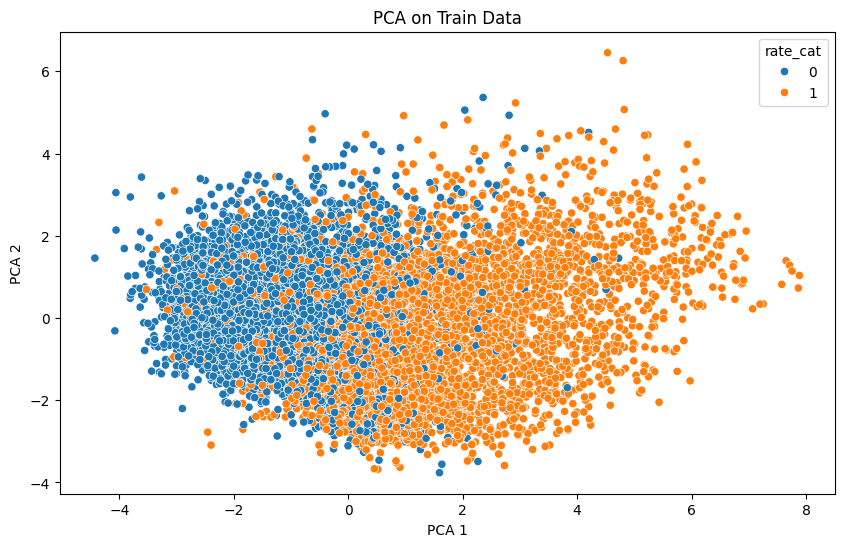

In [87]:
# run 2-dimension PCA on train_X, plot them, and label them with train_y
pca = PCA(n_components=2)
pca.fit(train_X)
train_X_pca = pca.transform(train_X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_X_pca[:, 0], y=train_X_pca[:, 1], hue=train_y)
plt.title('PCA on Train Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

From the plot, we can see a quite difference in two classes (1 as high, 0 as low). This also implies that a 2-dimension PCA already explains a high percentage of variance

In [88]:
# variance explained
print('Variance Explained:', pca.explained_variance_ratio_)

Variance Explained: [0.23937134 0.10870345]


It confirms that more than a third of variance is explained only using 2 dimensions rather than 17 features

### <a id='toc2_6_5_'></a>[LDA and QDA](#toc0_)

From the PCA plot, we may guess that the boundary of two classes would be quite linear, which suggests that a LDA would be better than a QDA. Let's see:

In [91]:
# LDA and QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(train_X, train_y)
print('LDA:')
print(report_model(lda))

qda = QuadraticDiscriminantAnalysis()
qda.fit(train_X, train_y)
print("QDA:")
print(report_model(qda))

LDA:
              Train      Test
Accuracy   0.883118  0.867742
Precision  0.902752  0.895594
F1         0.869790  0.850773
Recall     0.839150  0.810225
QDA:
              Train      Test
Accuracy   0.855284  0.852419
Precision  0.845435  0.849291
F1         0.844242  0.839614
Recall     0.843052  0.830156


### <a id='toc2_6_6_'></a>[Random Forest](#toc0_)

A random forest could potentially be a more accurate model, and also help us interpret what features would affect the ratings more, essentially answering our original question: **"What factors affect the rating of board games?"**

In [97]:
# use cross validation to find the best random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=618)
# finding the best 'n_estimators', 'min_samples_split', 'max_features'
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [5, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}
rf_cv = GridSearchCV(rf, param_grid, cv=5, error_score='raise')
rf_cv.fit(train_X, train_y)
# get best model and print parameters
best_rf = rf_cv.best_estimator_
print(best_rf)
report_model(best_rf)

RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=618)


,Train,Test
Accuracy,0.992336,0.896774
Precision,0.993689,0.905235
F1,0.991746,0.886826
Recall,0.989811,0.869151


In [99]:
best_rf.max_features

'sqrt'

Apparently random forest can achieve almost 100% accuracy on train data, and around 90% on test data, which is higher than what we hade before, and it could be improved if we explore more parameters combinations.

However, the most important part of a random forest is that we may explore the feature importance in the model:

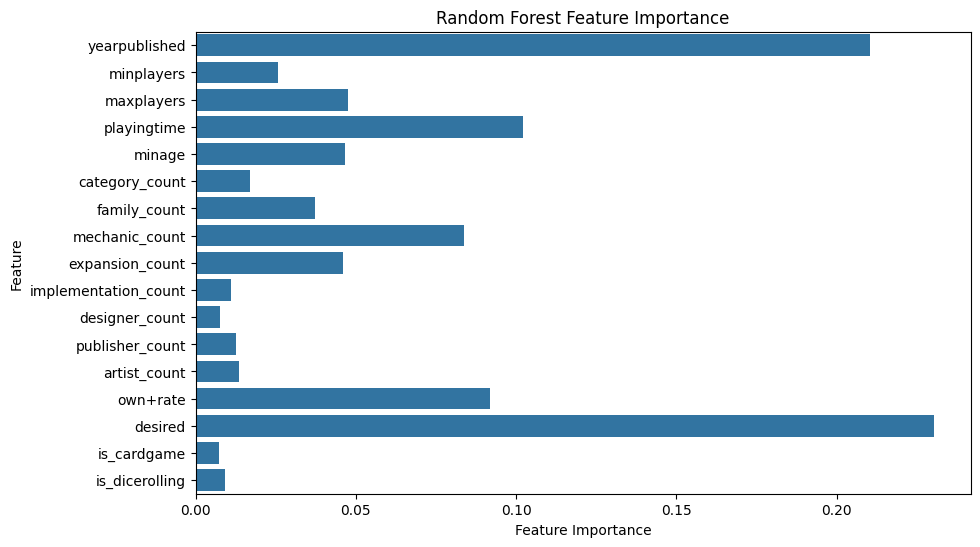

In [98]:
# plot feature importance of best_rf
plt.figure(figsize=(10, 6))
sns.barplot(x=best_rf.feature_importances_, y=feature_names)
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

From the plot, we may see that there are several feature which have quite high importance in classifying average ratings of the board games, including the year published, length of playing time, diversity in game mechanics, and the game popularity.

### <a id='toc2_6_7_'></a>[XGBOOST](#toc0_)

In [101]:
# xgboost
from xgboost import XGBClassifier

# use girdsearchcv to get best xgboost
xgb = XGBClassifier(random_state=618)
# parameters: gamma, max_depth, learning_rate, n_estimators
param_grid = {
    'gamma': [0, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200]
}
xgb_cv = GridSearchCV(xgb, param_grid, cv=5)
xgb_cv.fit(train_X, train_y)
# get best model and print parameters
best_xgb = xgb_cv.best_estimator_
print(best_xgb)
report_model(best_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=618, ...)


,Train,Test
Accuracy,0.955526,0.902419
Precision,0.957657,0.905694
F1,0.951914,0.893766
Recall,0.946239,0.882149


The XGBOOST model gives even higher accuracy on test set

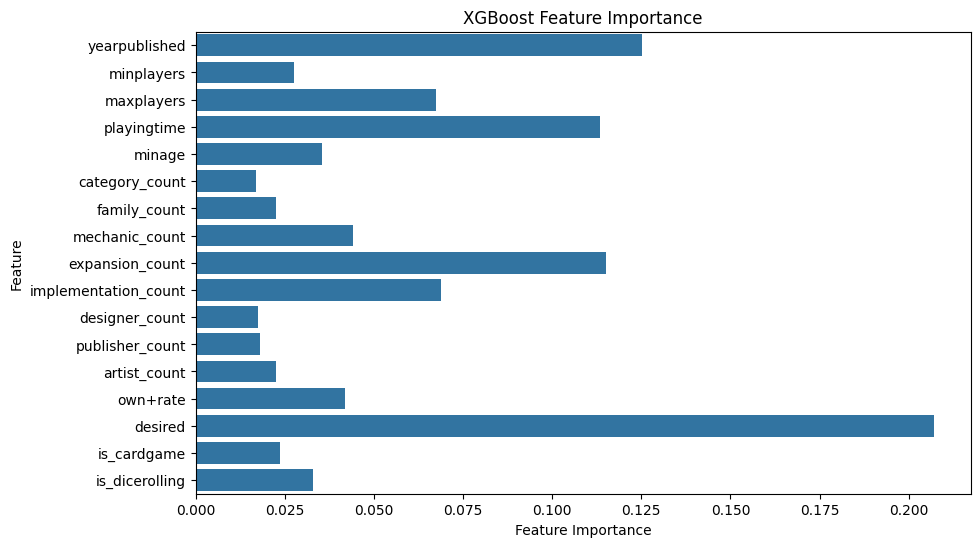

In [102]:
# plot importance in best_xgb
plt.figure(figsize=(10, 6))
sns.barplot(x=best_xgb.feature_importances_, y=feature_names)
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

Slightly different from the random forest, in xgboost, the year published, playing time, whether it has expansion, and popularity play the most important roles in the model.

### <a id='toc2_6_8_'></a>[Ensemble Model](#toc0_)

In [103]:
# ensemble the best logistic regression and random forest
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('logistic', best_logistic), ('rf', best_rf), ('xgb', best_xgb)], voting='soft')
ensemble.fit(train_X, train_y)
report_model(ensemble)

,Train,Test
Accuracy,0.954215,0.896371
Precision,0.960780,0.911091
F1,0.950252,0.885523
Recall,0.939952,0.861352


As the random forest and xgboost perform better than the logistic regression, we may expect the ensemble model having similar performance with random forest and xgboost on test set.

We may see a quite improvement in precision.

## <a id='toc2_7_'></a>[Interpretation, Conclusion, Reflection](#toc0_)

There are more models to explore which may give us a even higher accuracies and precisions than what we had, but the object of this project to to answer the question **"What factors affect the rating of board games?"**. Therefore, the interpretability of the model is crucial in out analysis. Logistic Regression has parameters on each features which may help us understand how each characteristic of a board game would affect the ratings, while random forest and xgboost keep track of the importance of features when training the splitting of tree nodes. Other models, such as SVM, LDA, KNN, may not provides as much information we would gain to guide future players and designers what a high-quality board game would be.

By looking at the coefficients in the logistic regression and the importance scores in random forest and xgboost, we may summarize what and how some features of the board games affect the ratings of the games:

- `yearpublished`. It plays a big role in all models. We may interpret that, a board game with a relatively larger `yearpublished`, which means the game is newer, in general, would tend to receive higher ratings by the players;
- `playingtime`. It is important in all models. We may see that, a board game with relatively longer playing time would in general receive higher ratings. This could be explained that a longer game is usually better designed, having more details and plots, or targeting a specific niche customer circle, which would tend to be liked by its user base;
- Diversity. Models suggest that having expansion package and more mechanics would lead to higher ratings. This is quite self-explanatory, as this kind of diversity usually implies a higher quality of the game, which is reflected on the ratings.
- Population. In our data processing, despite the correlations in the columns that reflect the popularity of the game, we kept two integrated features. In logistic regression the feature representing the amount of ownership and the amount of users who desire the game have opposite impact on the result. In tree/forest based models, the amount of users who desire the game shows a higher importance in the model. This could be misleading because of the correlations, but we may still argue that in general, if the game is desired by more people, the game would tend to receive higher ratings. However, the logic behind this interpretation could be questionable, as the causal relationship is likely in the reverse way: if the game has higher ratings, more people may mark it as 'wanted' on the website. In future we may take deeper study on the relationship of the popularity measurements and ratings.

<a id='reference'>
<strong>Reference</strong>
</a>